In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("/kaggle/input/georating-vseros-osn-3/train.tsv", sep="\t")
test = pd.read_csv("/kaggle/input/georating-vseros-osn-3/test.tsv", sep="\t")
reviews = pd.read_csv("/kaggle/input/georating-vseros-osn-3/reviews.txv/reviews.tsv", sep="\t")

In [4]:
train = train[train['target'] >= 1]

In [5]:
train_ids = set(train.id)
test_ids = set(test.id)

train_reviews = set(reviews.id) & set(train.id)
test_reviews = set(reviews.id) & set(test.id)

train_no = train_ids - train_reviews
test_no = test_ids - test_reviews

all_reviews = train_reviews | test_reviews

In [6]:
def cords(semi, mode):
    if mode == "lng":
        end1 = semi.find(",")
        return float(semi[1:end1])
    elif mode == "lat":
        start2 = semi.find(",")+2
        return semi[start2:-1]

In [7]:
train['lng'] = train['coordinates'].apply(lambda x: cords(x, mode="lng"))
train['lat'] = train['coordinates'].apply(lambda x: cords(x, mode="lat"))

test['lng'] = test['coordinates'].apply(lambda x: cords(x, mode="lng"))
test['lat'] = test['coordinates'].apply(lambda x: cords(x, mode="lat"))

In [8]:
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from tqdm import tqdm
import pandas as pd

In [9]:
geo_train = gpd.GeoDataFrame(
    train,
    geometry=gpd.points_from_xy(train.lng, train.lat),
    crs="EPSG:4326"
)

geo_test = gpd.GeoDataFrame(
    test,
    geometry=gpd.points_from_xy(test.lng, test.lat),
    crs="EPSG:4326"
)

In [10]:
from geopy.geocoders import Nominatim
from tqdm import tqdm
import time

# === 1. Инициализация геокодера ===
geolocator = Nominatim(user_agent="geo_filler")

# === 2. Функция для обратного геокодирования ===
def reverse_geocode(lat, lon, sleep_sec=1.0):
    """Возвращает адрес, город, улицу, район и регион по координатам"""
    try:
        location = geolocator.reverse((lat, lon), language="ru", timeout=15)
        if not location:
            return None, None, None, None
        
        addr = location.raw.get("address", {})
        city = (
            addr.get("city")
            or addr.get("town")
            or addr.get("village")
            or addr.get("hamlet")
        )
        district = addr.get("suburb") or addr.get("city_district")
        street = addr.get("road")
        region = addr.get("state")
        full_address = location.address
        
        return full_address, city, district, street, region
    except Exception as e:
        return None, None, None, None
    finally:
        # чтобы не попасть под rate limit Nominatim
        time.sleep(sleep_sec)


In [11]:
missing_rows = geo_train[geo_train['address'].isna()][["id", "lat", "lng"]].reset_index()

results = []
for i, row in tqdm(missing_rows.iterrows(), total=len(missing_rows), desc="Reverse geocoding"):
    res = reverse_geocode(row.lat, row.lng)
    results.append([row.id, res])

results

Reverse geocoding: 100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


[[16924,
  ('5 с1, Джамгаровская улица, Лосиноостровский район, Москва, Центральный федеральный округ, 141001, Россия',
   'Москва',
   'Лосиноостровский район',
   'Джамгаровская улица',
   'Москва')],
 [9264,
  ('6 с4, 1-й Дорожный проезд, район Чертаново Центральное, Москва, Центральный федеральный округ, 117545, Россия',
   'Москва',
   'район Чертаново Центральное',
   '1-й Дорожный проезд',
   'Москва')],
 [461,
  ('Столички, к1805, улица Каменка, 18-й микрорайон, район Крюково, Зеленоград, Москва, Центральный федеральный округ, 124365, Россия',
   'Зеленоград',
   'район Крюково',
   'улица Каменка',
   'Москва')],
 [13631,
  ('23, Петровский бульвар, 50, Тверской район, Москва, Центральный федеральный округ, 127051, Россия',
   'Москва',
   'Тверской район',
   'Петровский бульвар',
   'Москва')],
 [15327,
  ('236 с5, Ленинградское шоссе, Новосёлки, Молжаниновский район, Новоподрезково, Москва, Центральный федеральный округ, 141408, Россия',
   'Москва',
   'Молжаниновский райо

In [12]:
for ind, val in tqdm(results):
    geo_train.loc[geo_train[geo_train.id == ind].index[0], "address"] = val[0]

100%|██████████| 20/20 [00:00<00:00, 667.86it/s]


In [13]:
missing_rows = geo_test[geo_test['address'].isna()][["id", "lat", "lng"]].reset_index()

results = []
for i, row in tqdm(missing_rows.iterrows(), total=len(missing_rows), desc="Reverse geocoding"):
    res = reverse_geocode(row.lat, row.lng)
    results.append([row.id, res])

for ind, val in tqdm(results):
    geo_test.loc[geo_test[geo_test.id == ind].index, "address"] = val[0]

100%|██████████| 5/5 [00:00<00:00, 612.92it/s]


In [14]:
name_mapper = pd.concat([geo_train, geo_test]).name.value_counts().to_dict()
address_mapper = pd.concat([geo_train, geo_test]).address.value_counts().to_dict()

geo_train['name_freq'] = geo_train.name.map(name_mapper)
geo_train['address_freq'] = geo_train.address.map(address_mapper)

geo_test['name_freq'] = geo_test.name.map(name_mapper)
geo_test['address_freq'] = geo_test.address.map(address_mapper)

In [15]:
# === 1. Загружаем данные стран и городов ===
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))[["geometry", "name"]]
world = world.rename(columns={"name": "region"})

cities = gpd.read_file(gpd.datasets.get_path("naturalearth_cities")).to_crs("EPSG:4326")

# === 2. Удаляем конфликтующие колонки ===
for col in ["index_left", "index_right"]:
    geo_train = geo_train.drop(columns=col, errors="ignore")
    geo_test = geo_test.drop(columns=col, errors="ignore")

# === 3. Добавляем регион (страна) ===
geo_train = gpd.sjoin(geo_train, world, how="left", predicate="within")
geo_test = gpd.sjoin(geo_test, world, how="left", predicate="within")

# === 4. Находим ближайший город ===
# Сохраняем индексы, чтобы потом взять геометрию города
nearest_train = gpd.sjoin_nearest(
    geo_train, cities, how="left",
    distance_col="dist_to_city_deg",
    lsuffix="train", rsuffix="city"
)
nearest_test = gpd.sjoin_nearest(
    geo_test, cities, how="left",
    distance_col="dist_to_city_deg",
    lsuffix="test", rsuffix="city"
)

In [16]:
# === 5. Переводим угловое расстояние в километры ===
def deg_to_km(lat1, lon1, lat2, lon2):
    try:
        return geodesic((lat1, lon1), (lat2, lon2)).km
    except Exception:
        return None

# Извлекаем координаты города напрямую из GeoDataFrame cities
nearest_train["city_lat"] = nearest_train["index_city"].map(cities.geometry.y)
nearest_train["city_lon"] = nearest_train["index_city"].map(cities.geometry.x)
nearest_test["city_lat"] = nearest_test["index_city"].map(cities.geometry.y)
nearest_test["city_lon"] = nearest_test["index_city"].map(cities.geometry.x)

nearest_train["distance_to_center_km"] = nearest_train.apply(
    lambda r: deg_to_km(r.lat, r.lng, r.city_lat, r.city_lon),
    axis=1
)
nearest_test["distance_to_center_km"] = nearest_test.apply(
    lambda r: deg_to_km(r.lat, r.lng, r.city_lat, r.city_lon),
    axis=1
)

# === 6. Переименовываем и оставляем нужные колонки ===
nearest_train = nearest_train.rename(columns={"name": "city"})
nearest_test = nearest_test.rename(columns={"name": "city"})

geo_train = nearest_train
geo_test = nearest_test

In [17]:
geo_train = geo_train.reset_index(drop=True)
geo_test = geo_test.reset_index(drop=True)

In [18]:
import requests
import json

In [19]:
url = "https://api.hh.ru/metro/1"
response = requests.get(url)

if response.status_code == 200:
    metro_data = response.json()

In [20]:
metro_data.keys()

dict_keys(['id', 'name', 'lines'])

In [21]:
metros = []
for line in range(len(metro_data['lines'])):
    here = metro_data['lines'][line]['stations']
    for station in range(len(here)):
        metros.append([here[station]['name'], here[station]['lng'], here[station]['lat']])

metros = pd.DataFrame(metros, columns=['metro_name', 'lng', 'lat'])

geo_metros = gpd.GeoDataFrame(
    metros,
    geometry=gpd.points_from_xy(metros.lng, metros.lat),
    crs="EPSG:4326"
)
geo_metros

geo_metros = geo_metros.drop_duplicates(subset=['metro_name']).reset_index(drop=True)

geo_metros

,metro_name,lng,lat,geometry
0,Новокосино,37.864052,55.745113,POINT (37.86405 55.74511)
1,Новогиреево,37.814587,55.752237,POINT (37.81459 55.75224)
2,Перово,37.784220,55.750980,POINT (37.78422 55.75098)
3,Шоссе Энтузиастов,37.751703,55.758090,POINT (37.75170 55.75809)
4,Авиамоторная,37.717444,55.751933,POINT (37.71744 55.75193)
...,...,...,...,...
352,Генерала Тюленева,37.486032,55.626248,POINT (37.48603 55.62625)
353,Тютчевская,37.481415,55.618801,POINT (37.48141 55.61880)
354,Корниловская,37.479586,55.599411,POINT (37.47959 55.59941)
355,Коммунарка,37.468116,55.573540,POINT (37.46812 55.57354)


In [22]:
import numpy as np
from scipy.spatial import cKDTree
import pandas as pd

# === 0. Приводим к float ===
geo_train["lat"] = geo_train["lat"].astype(float)
geo_train["lng"] = geo_train["lng"].astype(float)
geo_metros["lat"] = geo_metros["lat"].astype(float)
geo_metros["lng"] = geo_metros["lng"].astype(float)

# === 1. Подготовим массивы координат ===
train_coords = np.deg2rad(np.c_[geo_train.lat, geo_train.lng])
metro_coords = np.deg2rad(np.c_[geo_metros.lat, geo_metros.lng])

# === 2. Создаём KDTree для метро ===
tree = cKDTree(metro_coords)

# === 3. Ищем 3 ближайших станции для каждой точки ===
dist_rad, idx = tree.query(train_coords, k=3)

# === 4. Переводим радианы → километры ===
dist_km = dist_rad * 6371

# === 5. Формируем таблицу результатов ===
nearest3 = []
for i in range(len(geo_train)):
    names = geo_metros.metro_name.iloc[idx[i]].tolist()
    distances = dist_km[i].tolist()
    nearest3.append({
        "nearest_metro_1": names[0],
        "dist_metro_1_km": distances[0],
        "nearest_metro_2": names[1],
        "dist_metro_2_km": distances[1],
        "nearest_metro_3": names[2],
        "dist_metro_3_km": distances[2],
    })

df_nearest3 = pd.DataFrame(nearest3)

geo_train = pd.concat([geo_train, df_nearest3], axis=1)

In [23]:
import numpy as np
from scipy.spatial import cKDTree
import pandas as pd

# === 0. Приводим к float ===
geo_test["lat"] = geo_test["lat"].astype(float)
geo_test["lng"] = geo_test["lng"].astype(float)
geo_metros["lat"] = geo_metros["lat"].astype(float)
geo_metros["lng"] = geo_metros["lng"].astype(float)

# === 1. Подготовим массивы координат ===
test_coords = np.deg2rad(np.c_[geo_test.lat, geo_test.lng])
metro_coords = np.deg2rad(np.c_[geo_metros.lat, geo_metros.lng])

# === 2. Создаём KDTree для метро ===
tree = cKDTree(metro_coords)

# === 3. Ищем 3 ближайших станции для каждой точки ===
dist_rad, idx = tree.query(test_coords, k=3)

# === 4. Переводим радианы → километры ===
dist_km = dist_rad * 6371

# === 5. Формируем таблицу результатов ===
nearest3 = []
for i in range(len(geo_test)):
    names = geo_metros.metro_name.iloc[idx[i]].tolist()
    distances = dist_km[i].tolist()
    nearest3.append({
        "nearest_metro_1": names[0],
        "dist_metro_1_km": distances[0],
        "nearest_metro_2": names[1],
        "dist_metro_2_km": distances[1],
        "nearest_metro_3": names[2],
        "dist_metro_3_km": distances[2],
    })

df_nearest3 = pd.DataFrame(nearest3)

geo_test = pd.concat([geo_test, df_nearest3], axis=1)

In [24]:
imp_places = [
  {
    "name": "Кремль",
    "lat": 55.752004,
    "lng": 37.617734
  },
  {
    "name": "Москва-Сити",
    "lat": 55.7476,
    "lng": 37.5320
  },
  {
    "name": "Патриаршие пруды",
    "lat": 55.763587,
    "lng": 37.592727
  },
  {
    "name": "ВДНХ",
    "lat": 55.821100,
    "lng": 37.641100
  },
  {
    "name": "МГУ (Ломоносовский проспект / главное здание)",
    "lat": 55.7033,
    "lng": 37.5301
  },
  {
    "name": "Хамовники (район)",
    "lat": 55.7370,
    "lng": 37.5760
  },
  {
    "name": "Якиманка (район)",
    "lat": 55.73139,
    "lng": 37.60389
  },
  {
    "name": "Арбат (улица)",
    "lat": 55.750950,
    "lng": 37.596534
  },
  {
    "name": "Тверская улица",
    "lat": 55.763903,
    "lng": 37.606478
  }
]

In [25]:
places = []
for place in imp_places:
    places.append([place['name'], place['lng'], place['lat']])

imp_places = pd.DataFrame(places, columns=["name", "lng", "lat"])

geo_places = gpd.GeoDataFrame(imp_places,
                          geometry=gpd.points_from_xy(imp_places.lng, imp_places.lat),
                          crs="EPSG:4326")
geo_places

,name,lng,lat,geometry
0,Кремль,37.617734,55.752004,POINT (37.61773 55.75200)
1,Москва-Сити,37.532000,55.747600,POINT (37.53200 55.74760)
2,Патриаршие пруды,37.592727,55.763587,POINT (37.59273 55.76359)
3,ВДНХ,37.641100,55.821100,POINT (37.64110 55.82110)
4,МГУ (Ломоносовский проспект / главное здание),37.530100,55.703300,POINT (37.53010 55.70330)
5,Хамовники (район),37.576000,55.737000,POINT (37.57600 55.73700)
6,Якиманка (район),37.603890,55.731390,POINT (37.60389 55.73139)
7,Арбат (улица),37.596534,55.750950,POINT (37.59653 55.75095)
8,Тверская улица,37.606478,55.763903,POINT (37.60648 55.76390)


In [26]:
from geopy.distance import geodesic
import pandas as pd

# Проверяем типы
geo_train["lat"] = geo_train["lat"].astype(float)
geo_train["lng"] = geo_train["lng"].astype(float)

# === 1. Считаем расстояния до каждого места ===
for i, row in tqdm(geo_places.iterrows()):
    place_name = row["name"]
    place_coords = (row["lat"], row["lng"])

    # создаём новую колонку с расстоянием в километрах
    geo_train[f"dist_to_{place_name.lower().replace(' ', '_')}_km"] = geo_train.apply(
        lambda r: geodesic((r.lat, r.lng), place_coords).km,
        axis=1
    )

9it [00:49,  5.50s/it]


In [27]:
from geopy.distance import geodesic
import pandas as pd

# Проверяем типы
geo_test["lat"] = geo_test["lat"].astype(float)
geo_test["lng"] = geo_test["lng"].astype(float)

# === 1. Считаем расстояния до каждого места ===
for i, row in tqdm(geo_places.iterrows()):
    place_name = row["name"]
    place_coords = (row["lat"], row["lng"])

    # создаём новую колонку с расстоянием в километрах
    geo_test[f"dist_to_{place_name.lower().replace(' ', '_')}_km"] = geo_test.apply(
        lambda r: geodesic((r.lat, r.lng), place_coords).km,
        axis=1
    )

9it [00:12,  1.34s/it]


In [28]:
geo_train["lat_sin"] = np.sin(np.radians(geo_train["lat"]))
geo_train["lat_cos"] = np.cos(np.radians(geo_train["lat"]))
geo_train["lng_sin"] = np.sin(np.radians(geo_train["lng"]))
geo_train["lng_cos"] = np.cos(np.radians(geo_train["lng"]))
# geo_train["geo_centrality"] = 1 / (1 + geo_train["dist_to_кремль_km"])

geo_test["lat_sin"] = np.sin(np.radians(geo_test["lat"]))
geo_test["lat_cos"] = np.cos(np.radians(geo_test["lat"]))
geo_test["lng_sin"] = np.sin(np.radians(geo_test["lng"]))
geo_test["lng_cos"] = np.cos(np.radians(geo_test["lng"]))
# geo_test["geo_centrality"]  = 1 / (1 + geo_test["dist_to_кремль_km"])

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
kremlin_coords = (55.752004, 37.617734)

def mkad_zone(lat, lng):
    d = geodesic((lat, lng), kremlin_coords).km
    if d < 5:      # внутри садового
        return 1
    elif d < 18:   # между Садовым и МКАД
        return 2
    else:          # за МКАД
        return 3

geo_train["mkad_zone"] = geo_train.apply(lambda r: mkad_zone(r.lat, r.lng), axis=1)
geo_test["mkad_zone"] = geo_test.apply(lambda r: mkad_zone(r.lat, r.lng), axis=1)

In [ ]:
# from sklearn.cluster import KMeans
# import numpy as np
# import pandas as pd

# # Объединяем train и test — чтобы кластеры были согласованы
# all_coords = np.vstack([
#     np.radians(np.c_[geo_train["lat"], geo_train["lng"]]),
#     np.radians(np.c_[geo_test["lat"], geo_test["lng"]])
# ])

# # Выбираем количество кластеров (примерно sqrt(N/2))
# n_clusters = int(np.sqrt(len(all_coords) / 2))
# print(f"Using {n_clusters} clusters")

# # Обучаем кластеризацию
# kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
# labels = kmeans.fit_predict(all_coords)

# # Разделяем обратно
# geo_train["geo_cluster"] = labels[:len(geo_train)]
# geo_test["geo_cluster"] = labels[len(geo_train):]

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(6,6))
# plt.scatter(geo_train.lng, geo_train.lat, c=geo_train.geo_cluster, s=5, cmap="tab20")
# plt.title("Geo Clusters")
# plt.show()

In [31]:
!pip install h3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.6 MB/s eta 0:00:0000:01


In [32]:
!pip install h3

from h3.api import basic_str as h3

def latlng_to_h3(lat, lng, resolution=7):
    return h3.latlng_to_cell(lat, lng, resolution)

geo_train["h3_7"] = geo_train.apply(lambda r: latlng_to_h3(r.lat, r.lng, 7), axis=1)
geo_test["h3_7"] = geo_test.apply(lambda r: latlng_to_h3(r.lat, r.lng, 7), axis=1)
geo_train["h3_8"] = geo_train.apply(lambda r: latlng_to_h3(r.lat, r.lng, 8), axis=1)
geo_test["h3_8"] = geo_test.apply(lambda r: latlng_to_h3(r.lat, r.lng, 8), axis=1)
geo_train["h3_9"] = geo_train.apply(lambda r: latlng_to_h3(r.lat, r.lng, 9), axis=1)
geo_test["h3_9"] = geo_test.apply(lambda r: latlng_to_h3(r.lat, r.lng, 9), axis=1)

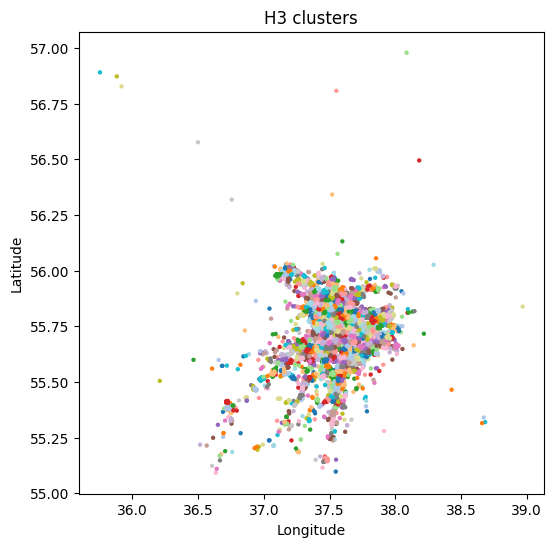

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))
sns.scatterplot(
    data=geo_train,
    x="lng",
    y="lat",
    hue=geo_train["h3_7"].astype("category").cat.codes,  # числовой цветовой код
    palette="tab20",
    s=10,
    linewidth=0
)
plt.title("H3 clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend([],[], frameon=False)  # убираем легенду
plt.show()

# Reviews

In [34]:
pip install -U "transformers==4.42.4" "huggingface_hub<0.24"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 86.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.8/402.8 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 39.9 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 1.0.0rc2
    Uninstalling huggingface-hub-1.0.0rc2:
      Successfully uninstalled huggingface-hub-1.0.0rc2
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beha

In [35]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

2025-10-21 13:09:09.759742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761052150.006604      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761052150.079749      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
class RubertRegressor(nn.Module):
    def __init__(self, model_name="cointegrated/rubert-tiny2"):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.2)
        self.regressor = nn.Linear(self.encoder.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = outputs.last_hidden_state[:, 0, :]  # [CLS]
        x = self.dropout(cls_emb)
        return self.regressor(x).squeeze(-1)


In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, texts, ratings, tokenizer, max_len=256):
        self.texts = texts
        self.ratings = ratings
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # ✅ используем позиционный доступ
        text = self.texts.iloc[idx] if isinstance(self.texts, pd.Series) else self.texts[idx]
        label = self.ratings.iloc[idx] if isinstance(self.ratings, pd.Series) else self.ratings[idx]

        item = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in item.items()}
        item["labels"] = torch.tensor(label, dtype=torch.float)
        return item

In [ ]:
import torch
from torch import nn
from transformers import AdamW, get_cosine_schedule_with_warmup
from tqdm import tqdm

# === 1. Модель ===
class RubertRegressor(nn.Module):
    def __init__(self, model_name="cointegrated/rubert-tiny2", dropout=0.2):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.regressor = nn.Linear(self.encoder.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = outputs.last_hidden_state[:, 0, :]  # [CLS] токен
        x = self.dropout(cls_emb)
        return self.regressor(x).squeeze(-1)


# === 2. Тренировка ===
def train_model(model, train_loader, val_loader, epochs=3, lr=2e-5, warmup_ratio=0.1):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    loss_fn = nn.L1Loss()  # MAE лучше сходится для рейтингов

    total_steps = len(train_loader) * epochs
    warmup_steps = int(total_steps * warmup_ratio)

    # ✅ Cosine Annealing with Warmup
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            preds = model(batch["input_ids"], batch["attention_mask"])
            loss = loss_fn(preds, batch["labels"])

            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"\n🟢 Train loss: {avg_train_loss:.4f}")

        # === Валидация ===
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                preds = model(batch["input_ids"], batch["attention_mask"])
                val_loss += loss_fn(preds, batch["labels"]).item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"🔵 Val loss: {avg_val_loss:.4f}\n")

    print("✅ Обучение завершено.")

In [ ]:
# === 1. Создание id2rate маппера ===
id2rate = train.set_index("id")['target'].to_dict()
reviews['target'] = reviews['id'].map(id2rate).fillna(-1)

# === 2. Отфильтровываем только те, где есть рейтинг ===
reviews_train = reviews[reviews['target'] != -1].dropna(subset=['text'])
reviews_train = reviews_train[reviews_train['text'].str.strip().astype(bool)]


unique_ids = reviews_train['id'].unique()
train_ids, val_ids = train_test_split(
    unique_ids,
    test_size=0.1,
    random_state=42,
)

train_subset = reviews_train[reviews_train['id'].isin(train_ids)].reset_index(drop=True)
val_subset = reviews_train[reviews_train['id'].isin(val_ids)].reset_index(drop=True)

train_texts = train_subset['text']
train_ratings = train_subset['target']
val_texts = val_subset['text']
val_ratings = val_subset['target']

# === 4. Tokenizer и Collator ===
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# === 5. Dataset и DataLoader ===
train_dataset = ReviewDataset(train_texts, train_ratings, tokenizer)
val_dataset = ReviewDataset(val_texts, val_ratings, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True, collate_fn=collator)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=False, collate_fn=collator)

In [ ]:
model = RubertRegressor("cointegrated/rubert-tiny2")
train_model(model, train_loader, val_loader, epochs=1, lr=3e-5, warmup_ratio=0.1)

In [ ]:
model.encoder.save_pretrained("./rubert-finetuned")
tokenizer.save_pretrained("./rubert-finetuned")

In [36]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from tqdm import tqdm

# === 1. Dataset ===
class InferenceDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=256):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx] if hasattr(self.texts, "iloc") else self.texts[idx]
        return self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_len,
            padding=False  # не трогаем паддинг, collator сделает сам
        )

# === 2. Основная функция инференса ===
def get_embeddings_from_encoder(texts, model_path="./rubert-finetuned", batch_size=64):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Загружаем энкодер и токенайзер
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path).to(device)
    model.eval()

    # Подготавливаем данные
    dataset = InferenceDataset(texts, tokenizer)
    collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collator)

    all_embeddings = []

    # Инференс
    with torch.no_grad():
        for batch in tqdm(loader, desc="Embedding texts"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            # Используем [CLS]-токен
            cls_emb = outputs.last_hidden_state[:, 0, :]
            all_embeddings.append(cls_emb.detach().cpu().numpy())

    return np.vstack(all_embeddings)

In [37]:
# Загружаем все тексты
texts = reviews["text"].reset_index(drop=True)
embeddings = get_embeddings_from_encoder(texts, model_path="./rubert-finetuned", batch_size=64)
embeddings.shape

Embedding texts: 100%|██████████| 6877/6877 [02:28<00:00, 46.46it/s]


(440082, 312)

# FEATS & DATA

In [38]:
mapper = reviews.groupby("id").count().to_dict()
for i in range(embeddings.shape[1]):
    reviews[f"emb_{i}"] = embeddings[:, i]

In [39]:
embs = reviews.drop(columns="text").groupby("id").mean().reset_index()

In [40]:
train_df = pd.merge(geo_train, embs, how="left", on=['id'])
test_df = pd.merge(geo_test, embs, how="left", on=["id"])

In [ ]:
# reviews_train = reviews[reviews["id"].isin(geo_train["id"])]#.drop(columns="target")
# reviews_test = reviews[reviews["id"].isin(geo_test["id"])]#.drop(columns="target")

# train_df = reviews_train.merge(geo_train,
#                         on="id",
#                         how="left")

# test_df = reviews_test.merge(geo_test,
#                         on="id",
#                         how="left")

# train_no_reviews = geo_train[geo_train.id.isin(train_no)]
# train_no_reviews = pd.concat([train_no_reviews for i in range(7)])
# test_no_reviews = geo_test[geo_test.id.isin(test_no)]

# train_df = pd.concat([train_df, train_no_reviews])
# test_df = pd.concat([test_df, test_no_reviews])

# train_df = train_df.rename({"name_train": "name"}, axis=1)
# test_df = test_df.rename({"name_test": "name"}, axis=1)

In [41]:
train_df['cnt'] = train_df["id"].apply(lambda x: mapper[x] if x in mapper.keys() else 0)
test_df['cnt'] = test_df["id"].apply(lambda x: mapper[x] if x in mapper.keys() else 0)

# CTB

In [42]:
mapper = reviews.groupby("id").count().to_dict()
test_df = test_df.rename({"name_test": "name"}, axis=1)
train_df = train_df.rename({"name_train": "name"}, axis=1)

In [ ]:
# corrs = train_df.drop(columns=["name", "address", "nearest_metro_1", "nearest_metro_2", "nearest_metro_3", 'category', 'h3_7', 'coordinates',
#                               'geometry', 'id', 'region', 'target', 'name_city', 'h3_7', 'h3_8', 'h3_9']).corr().abs()
# corrs

In [ ]:
# upper = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool))
# to_drop = {col for col in upper.columns if any(upper[col] > 0.99)}

In [43]:
target_col = 'target'

drop1 = {'childrens_websites_1000m', 'childrens_transport_1000m', 'mean_income_300m', 'childrens_transport_300m', 'children_goods_for_walks_and_travel_1000m', 'train_ticket_order_300m'}
drop_cols = {
    target_col, "id", "coordinates", "geometry", "index_right",
    "region", "index_city", "city_lat", "city_lon", "dist_to_city_deg",
    "name_city", "mean_rating_1km", "mean_rating_2km", "text", "target",
    "log_target", "train", "random_col"
}
another_dropper = {"anime_300m", "mortgage_1000m", "doramas_300m"}
[drop_cols.add(col) for col in another_dropper]
[drop_cols.add(col) for col in drop1]
# [drop_cols.add(col) for col in for_example]

train_cols = [c for c in train_df.columns if c not in drop_cols]
cat_features = ["name", "nearest_metro_1", "nearest_metro_2", "nearest_metro_3", 'category', 'address', 'h3_7', 'h3_8', 'h3_9']

In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def split_by_id_overlap(
    df: pd.DataFrame,
    id_col: str = "id",
    test_size: float = 0.1,          # доля id, которые окажутся в валидации (по id)
    overlap_frac: float = 0.2,       # доля id, которые будут встречаться и в train, и в valid
    overlap_valid_frac: float = 0.5, # какую долю строк overlap-id отдать в valid
    random_state: int = 42,
):
    """
    Возвращает (train_df, valid_df, info).
    - ~test_size доля уникальных id окажется в valid (по id).
    - ~overlap_frac доля уникальных id окажется в обеих частях (если у id >= 2 строк).
    - строки не дублируются.
    """

    rng = np.random.RandomState(random_state)
    # Уникальные id и их кратность
    id_counts = df[id_col].value_counts()
    ids_all = id_counts.index.to_numpy()
    n_ids = len(ids_all)

    # Цели по количеству id
    n_valid_ids_target = max(1, int(round(test_size * n_ids)))
    # кандидаты на overlap — только id с >= 2 строк
    overlap_candidates = id_counts[id_counts >= 2].index.to_numpy()
    n_overlap_ids_target = int(round(overlap_frac * n_ids))
    n_overlap_ids_target = min(n_overlap_ids_target, len(overlap_candidates))

    # выбор множеств id
    rng.shuffle(overlap_candidates)
    overlap_ids = set(overlap_candidates[:n_overlap_ids_target])

    # valid-exclusive id: добираем, чтобы всего id в valid было n_valid_ids_target
    remaining_ids = np.array([_id for _id in ids_all if _id not in overlap_ids])
    rng.shuffle(remaining_ids)
    n_valid_exclusive = max(0, n_valid_ids_target - len(overlap_ids))
    valid_exclusive_ids = set(remaining_ids[:n_valid_exclusive])

    # остальное уйдёт в train-exclusive
    train_exclusive_ids = set(remaining_ids[n_valid_exclusive:])

    # Маски базовых частей (по id)
    train_mask = df[id_col].isin(train_exclusive_ids)
    valid_mask = df[id_col].isin(valid_exclusive_ids)

    # Для overlap-id делим строки между train/valid
    if overlap_ids:
        part = df[df[id_col].isin(overlap_ids)].copy()
        # случайная метка на строку
        part["_u"] = rng.rand(len(part))
        # предварительное деление по заданной доле
        prelim_valid = part["_u"] < overlap_valid_frac

        # гарантируем минимум 1 строку в обеих частях для каждого overlap-id
        valid_idx = []
        train_idx = []
        for gid, grp in part.groupby(id_col, sort=False):
            if len(grp) == 1:
                # одна строка — нельзя пересечь честно, отправим её в train (или valid)
                train_idx.extend(grp.index.tolist())
                continue
            vmask = prelim_valid.loc[grp.index].values
            # если всё ушло в одну часть — принудительно перекинем одну строку
            if not vmask.any():
                vmask[0] = True
            if vmask.all():
                vmask[0] = False
            valid_idx.extend(grp.index[vmask].tolist())
            train_idx.extend(grp.index[~vmask].tolist())

        train_mask.loc[train_idx] = True
        valid_mask.loc[valid_idx] = True

    # Собираем сплиты
    train_df = df.loc[train_mask].reset_index(drop=True)
    valid_df = df.loc[valid_mask].reset_index(drop=True)

    # Диагностика по id
    ids_train = set(train_df[id_col].unique())
    ids_valid = set(valid_df[id_col].unique())
    ids_overlap_actual = ids_train & ids_valid

    info = {
        "n_ids_total": n_ids,
        "n_ids_valid_target": n_valid_ids_target,
        "n_ids_valid_actual": len(ids_valid),
        "overlap_frac_target": overlap_frac,
        "n_overlap_ids_target": n_overlap_ids_target,
        "n_overlap_ids_actual": len(ids_overlap_actual),
        "overlap_frac_actual": len(ids_overlap_actual) / n_ids if n_ids else 0.0,
        "note_singletons_skipped": int((id_counts == 1).sum()),  # id с 1 строкой не могут честно пересекаться
    }
    return train_df, valid_df, info

In [45]:
tr_df, va_df, info = split_by_id_overlap(
    train_df, id_col="id",
    test_size=0.1,        # ~10% id в валидации
    overlap_frac=0.0,     # ~20% id встречаются и там, и там
    overlap_valid_frac=0.5,
    random_state=42
)
print(info)

X_train = tr_df[train_cols + ["id"]]; y_train = tr_df[target_col]
X_valid = va_df[train_cols + ["id"]]; y_valid = va_df[target_col]

{'n_ids_total': 37119, 'n_ids_valid_target': 3712, 'n_ids_valid_actual': 3712, 'overlap_frac_target': 0.0, 'n_overlap_ids_target': 0, 'n_overlap_ids_actual': 0, 'overlap_frac_actual': 0.0, 'note_singletons_skipped': 37119}


In [46]:
from catboost import CatBoostRegressor

In [47]:
model = CatBoostRegressor(
    iterations=5000,
    depth=8,
    learning_rate=0.03,
    loss_function="MAE",
    eval_metric="MAE",
    random_seed=42,
    early_stopping_rounds=100,
    cat_features=cat_features,
    verbose=100,
    task_type="GPU"
)

model.fit(
    X_train[train_cols], y_train,
    eval_set=(X_valid[train_cols], y_valid),
    use_best_model=True
)

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.3251174	test: 0.3220246	best: 0.3220246 (0)	total: 5.22s	remaining: 7h 15m 2s
100:	learn: 0.2428145	test: 0.2432691	best: 0.2432691 (100)	total: 21.2s	remaining: 17m 10s
200:	learn: 0.2343109	test: 0.2366529	best: 0.2366529 (200)	total: 36.7s	remaining: 14m 35s
300:	learn: 0.2288278	test: 0.2333712	best: 0.2333712 (300)	total: 51.9s	remaining: 13m 30s
400:	learn: 0.2236713	test: 0.2316572	best: 0.2316572 (400)	total: 1m 7s	remaining: 12m 51s
500:	learn: 0.2188989	test: 0.2302154	best: 0.2302013 (498)	total: 1m 22s	remaining: 12m 21s
600:	learn: 0.2147158	test: 0.2292623	best: 0.2292623 (600)	total: 1m 37s	remaining: 11m 55s
700:	learn: 0.2109411	test: 0.2285333	best: 0.2285327 (699)	total: 1m 53s	remaining: 11m 33s
800:	learn: 0.2073329	test: 0.2279465	best: 0.2279432 (799)	total: 2m 8s	remaining: 11m 13s
900:	learn: 0.2039439	test: 0.2276256	best: 0.2276175 (898)	total: 2m 23s	remaining: 10m 54s
1000:	learn: 0.2007703	test: 0.2272816	best: 0.2272724 (999)	total: 2m 39s	rem

In [48]:
X_valid['predict'] = model.predict(X_valid)

In [49]:
from sklearn.metrics import mean_absolute_error
# predicter = X_valid[['id', 'predict', 'true']].groupby("id")[['predict', 'true']].agg('median')
mean_absolute_error(X_valid.predict, y_valid)

0.2249697589537989

In [50]:
model = CatBoostRegressor(
    iterations=2100,
    depth=8,
    learning_rate=0.03,
    loss_function="MAE",
    eval_metric="MAE",
    random_seed=42,
    early_stopping_rounds=100,
    cat_features=cat_features,
    verbose=100,
    task_type="GPU"
)

model.fit(
    train_df[train_cols], train_df[target_col],
)

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.3248031	total: 171ms	remaining: 5m 59s
100:	learn: 0.2422247	total: 16.3s	remaining: 5m 21s
200:	learn: 0.2331318	total: 31.6s	remaining: 4m 58s
300:	learn: 0.2282197	total: 46.6s	remaining: 4m 38s
400:	learn: 0.2234817	total: 1m 2s	remaining: 4m 22s
500:	learn: 0.2192882	total: 1m 17s	remaining: 4m 6s
600:	learn: 0.2154727	total: 1m 32s	remaining: 3m 50s
700:	learn: 0.2119968	total: 1m 47s	remaining: 3m 35s
800:	learn: 0.2087926	total: 2m 3s	remaining: 3m 19s
900:	learn: 0.2057700	total: 2m 18s	remaining: 3m 4s
1000:	learn: 0.2031371	total: 2m 33s	remaining: 2m 48s
1100:	learn: 0.2003180	total: 2m 49s	remaining: 2m 33s
1200:	learn: 0.1979663	total: 3m 4s	remaining: 2m 17s
1300:	learn: 0.1953035	total: 3m 19s	remaining: 2m 2s
1400:	learn: 0.1929771	total: 3m 34s	remaining: 1m 47s
1500:	learn: 0.1906836	total: 3m 50s	remaining: 1m 31s
1600:	learn: 0.1885375	total: 4m 5s	remaining: 1m 16s
1700:	learn: 0.1862222	total: 4m 21s	remaining: 1m 1s
1800:	learn: 0.1839956	total: 4m 3

In [51]:
test_df['target'] = model.predict(test_df[train_cols])

In [52]:
sample = test_df[['id', 'target']].groupby("id")['target'].agg(['mean']).copy()
sample = sample.reset_index().rename({"mean": "target"}, axis=1)
sample.loc[sample[sample['target'] < 0].index, 'target'] = 0

In [53]:
sample.to_csv("geo_subm.csv", index=False)

<Axes: xlabel='target', ylabel='Count'>

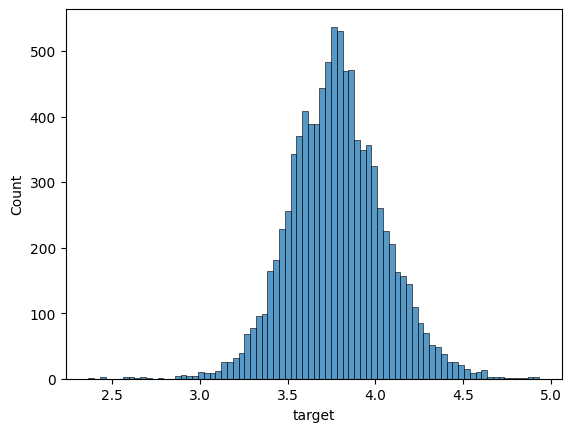

In [48]:
sns.histplot(sample.target)

In [49]:
sample

,id,target
0,2,3.513716
1,23,4.041457
2,28,3.757328
3,30,3.799227
4,34,3.722849
...,...,...
9271,50351,3.445459
9272,50352,3.721241
9273,50356,3.860841
9274,50368,4.188426


In [ ]:
1 / (1 + 0.27)

# FEATURE IMPORTANCE

In [ ]:
imp = model.get_feature_importance()  # без data/Pool
fi = pd.Series(imp, index=X_train[train_cols].columns).sort_values(ascending=False)

In [ ]:
for_example = fi[fi <= fi[fi.index == "random_col"][0]].index.tolist()

In [ ]:
target_col = 'target'

drop1 = {'childrens_websites_1000m', 'childrens_transport_1000m', 'mean_income_300m', 'childrens_transport_300m', 'children_goods_for_walks_and_travel_1000m', 'train_ticket_order_300m'}
drop_cols = {
    target_col, "coordinates", "geometry", "index_right",
    "region", "index_city", "city_lat", "city_lon", "dist_to_city_deg",
    "name_city", "mean_rating_1km", "mean_rating_2km", "text", "target",
    "log_target", "h3_7", "train", "dist_to_вднх_km", "anime_300m", "mortgage_1000m", "doramas_300m"
}
[drop_cols.add(col) for col in drop1]

train_cols = [c for c in geo_train.columns if c not in drop_cols]
cat_features = ["name", "address", "nearest_metro_1", "nearest_metro_2", "nearest_metro_3", "category"]

In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import pandas as pd

geo_train['train'] = 1
geo_test['train'] = 0

dataframe = pd.concat([geo_train.sample(9276), geo_test])

In [ ]:
X = dataframe[train_cols]
y = dataframe["train"]

In [ ]:
model = CatBoostRegressor(
    iterations=1000,
    depth=8,
    learning_rate=0.03,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    early_stopping_rounds=100,
    cat_features=cat_features,
    verbose=100,
    task_type="GPU"
)

model.fit(
    X[train_cols], y,
)

In [ ]:
imp = model.get_feature_importance()

In [ ]:
imp = model.get_feature_importance()  # без data/Pool
fi = pd.Series(imp, index=X.columns).sort_values(ascending=False)

In [ ]:
fi.head(10)